<a href="https://colab.research.google.com/github/Seminahn01/DS4002-Project1/blob/main/Sentimentanalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error


In [2]:
# Download necessary NLP data
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [3]:
# Initialize VADER
sia = SentimentIntensityAnalyzer()

In [5]:
# Load dataset
df = pd.read_csv("/content/movie_data_final.csv")

# Display dataset information
print(df.head())

   Unnamed: 0           title  review_id  \
0           1  101 Dalmatians      12794   
1           2  101 Dalmatians      12792   
2           3  101 Dalmatians      12791   
3           4  101 Dalmatians      12795   
4           5  101 Dalmatians      12793   

                                         review_text  lifetime_gross  \
0  Cast: Glenn Close, Jeff Daniels, Joely Richard...       320689294   
1  Part vamp, part tramp, and all camp, Glenn Clo...       320689294   
2  Cast: Glenn Close, Jeff Daniels, Joely Richard...       320689294   
3  Tragic, perhaps, the fate that befalls the Dis...       320689294   
4  Well, another new Disney movie is coming out a...       320689294   

   release_year  
0          1996  
1          1996  
2          1996  
3          1996  
4          1996  


In [7]:
# Perform sentiment analysis
df["sentiment_score"] = df["review_text"].apply(lambda x: sia.polarity_scores(str(x))["compound"])

In [9]:
# Calculate review length
df["review_length"] = df["review_text"].apply(lambda x: len(str(x).split()))

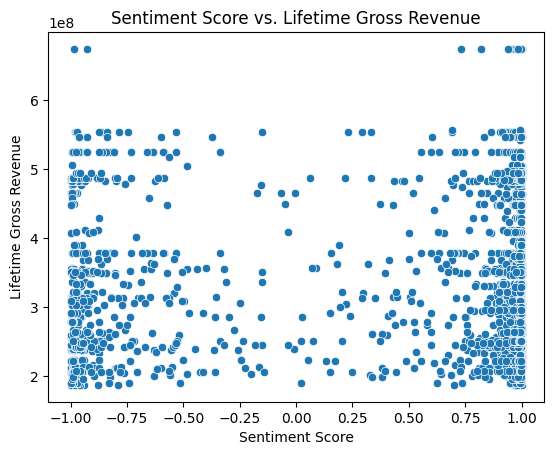

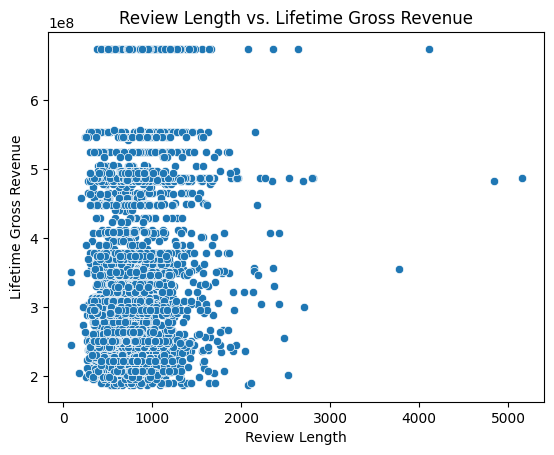

In [12]:
# Exploratory Data Analysis (EDA)
sns.scatterplot(data=df, x="sentiment_score", y="lifetime_gross")
plt.title("Sentiment Score vs. Lifetime Gross Revenue")
plt.xlabel("Sentiment Score")
plt.ylabel("Lifetime Gross Revenue")
plt.show()

sns.scatterplot(data=df, x="review_length", y="lifetime_gross")
plt.title("Review Length vs. Lifetime Gross Revenue")
plt.xlabel("Review Length")
plt.ylabel("Lifetime Gross Revenue")
plt.show()